Assumption: If the candidate resume contains similar tagging with the job discription, we can consider to recommand the candidate to apply for this job. 

## Library

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorlover as cl
import plotly
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

## Read in data

Each row represent a job posting on LinkedIn, and I substract the required skills in the job discription.

In [128]:
df = pd.read_csv('jobs_df_linkedin3.csv')
df.head()

,main_skill,sub_skill
0,Big Data Processing,"['Apache Hive', 'Data Partitioning', 'Data Lak..."
1,Big Data Processing,"['Data Partitioning', 'Apache NiFi', 'Data Lak..."
2,Experimental Design,"['Crossover Design', 'Longitudinal Studies', '..."
3,Big Data Processing,"['Apache Flink', 'Elastic MapReduce', 'Apache ..."
4,Database Management,"['NoSQL', 'SQL', 'Indexing', 'MySQL', 'SQLite'..."


In [129]:
len(df)

10000

## Preprocessing

Natural Language Preprocessing to make the documents `sub_skill` ready for modeling

In [130]:
#nltk.download('stopwords') 

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(text):
    text = re.sub(r'\n', ' ', text)  # Remove newline characters
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] #actually not needed because each document is now a group of skills, all noun 
    return words

df['processed'] = df['sub_skill'].apply(preprocess)
df['processed'] = df['processed'].apply(lambda x: ' '.join(x))

In [131]:
df['processed'].iloc[2]

'crossover design longitudinal study design experiment randomized controlled trial rcts r sample size calculation minitab survey design jmp ab testing'

## LDA Modeling

* TF-IDF Vectorizing

In [132]:
# Fit the tf-idf vectorizer 
vectorizer = TfidfVectorizer(ngram_range=(1, 1)) #Consider one gram to keep it simple
tfidf_matrix = vectorizer.fit_transform(df['processed'])
tokens = vectorizer.get_feature_names_out()

doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(tfidf_matrix)]
tfidf = pd.DataFrame(data=tfidf_matrix.toarray(), index=doc_names,
                  columns=tokens)
tfidf.head()


,ab,access,airflow,altair,analysis,anova,ansible,apache,architecture,aws,...,tree,trial,tuning,unsupervised,variable,version,versioning,vision,vmware,xgboost
Doc0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.441426,0.239014,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.543089,0.220545,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc2,0.225027,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.22757,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.643842,0.209168,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.22905,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Fitting LDA Model

I manually find the best number of components, a reliable way is to compute the topic coherence for different number of topics and choose the model that gives the highest topic coherence. The goal is to choose a number of topics that minimize the perplexity compared to other numbers of topics

In [133]:
# Fit the LDA model
lda = LatentDirichletAllocation(n_components=9, random_state=420)
lda.fit(tfidf_matrix )

LatentDirichletAllocation(n_components=9, random_state=420)

In [134]:
import pickle
with open('lda_model.pkl', 'wb') as lda_file:
    pickle.dump(lda, lda_file)
# Save the CountVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as cv_file:
    pickle.dump(vectorizer, cv_file)

## Topic/Tag Analysis

Below is the top 10 frequent words in each topic, serving as a reference of assigning tags

In [135]:
for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]))

Topic 0:
analysis statistic anova spss nonparametric descriptive sa statistical programming multivariate
Topic 1:
apache mapreduce data hdfs bigquery hdinsight lake architecture spark partitioning
Topic 2:
model continuous deployment kubeflow collection balancing load scalability orchestration pipeline
Topic 3:
design testing confounding variable calculation sample size ab scipy study
Topic 4:
database sql postgresql denormalization normalization mongodb redis stored procedure cassandra
Topic 5:
cloud azure storage aws serverless vmware ansible openstack lambda terraform
Topic 6:
learning neural network kera clustering vision computer language natural processing
Topic 7:
altair heatmaps d3js folium plotly bokeh seaborn bi excel storytelling
Topic 8:
apache data integration sql numpy flume beautifulsoupreshaping integrator talend snowflake


* Assign a tag to each topic based on top words

In [145]:
topic_names = [
    "Statistical Analysis",
    "Big Data Processing",
    "MLOps",
    "Experimental Design",
    "Database Management",
    "Cloud Computing",
    "Machine Learning Development",
    "Data Visualization",
    "ETL",
]

In [146]:
def display_topics(model, feature_names, no_top_words, topic_names):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx} - {topic_names[topic_idx]}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("\nTop words per topic:")
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words, topic_names)


Top words per topic:
Topic 0 - Statistical Analysis:
analysis statistic anova spss nonparametric descriptive sa statistical programming multivariate
Topic 1 - Big Data Processing:
apache mapreduce data hdfs bigquery hdinsight lake architecture spark partitioning
Topic 2 - MLOps:
model continuous deployment kubeflow collection balancing load scalability orchestration pipeline
Topic 3 - Experimental Design:
design testing confounding variable calculation sample size ab scipy study
Topic 4 - Database Management:
database sql postgresql denormalization normalization mongodb redis stored procedure cassandra
Topic 5 - Cloud Computing:
cloud azure storage aws serverless vmware ansible openstack lambda terraform
Topic 6 - Machine Learning Development:
learning neural network kera clustering vision computer language natural processing
Topic 7 - Data Visualization:
altair heatmaps d3js folium plotly bokeh seaborn bi excel storytelling
Topic 8 - ETL:
apache data integration sql numpy flume beaut

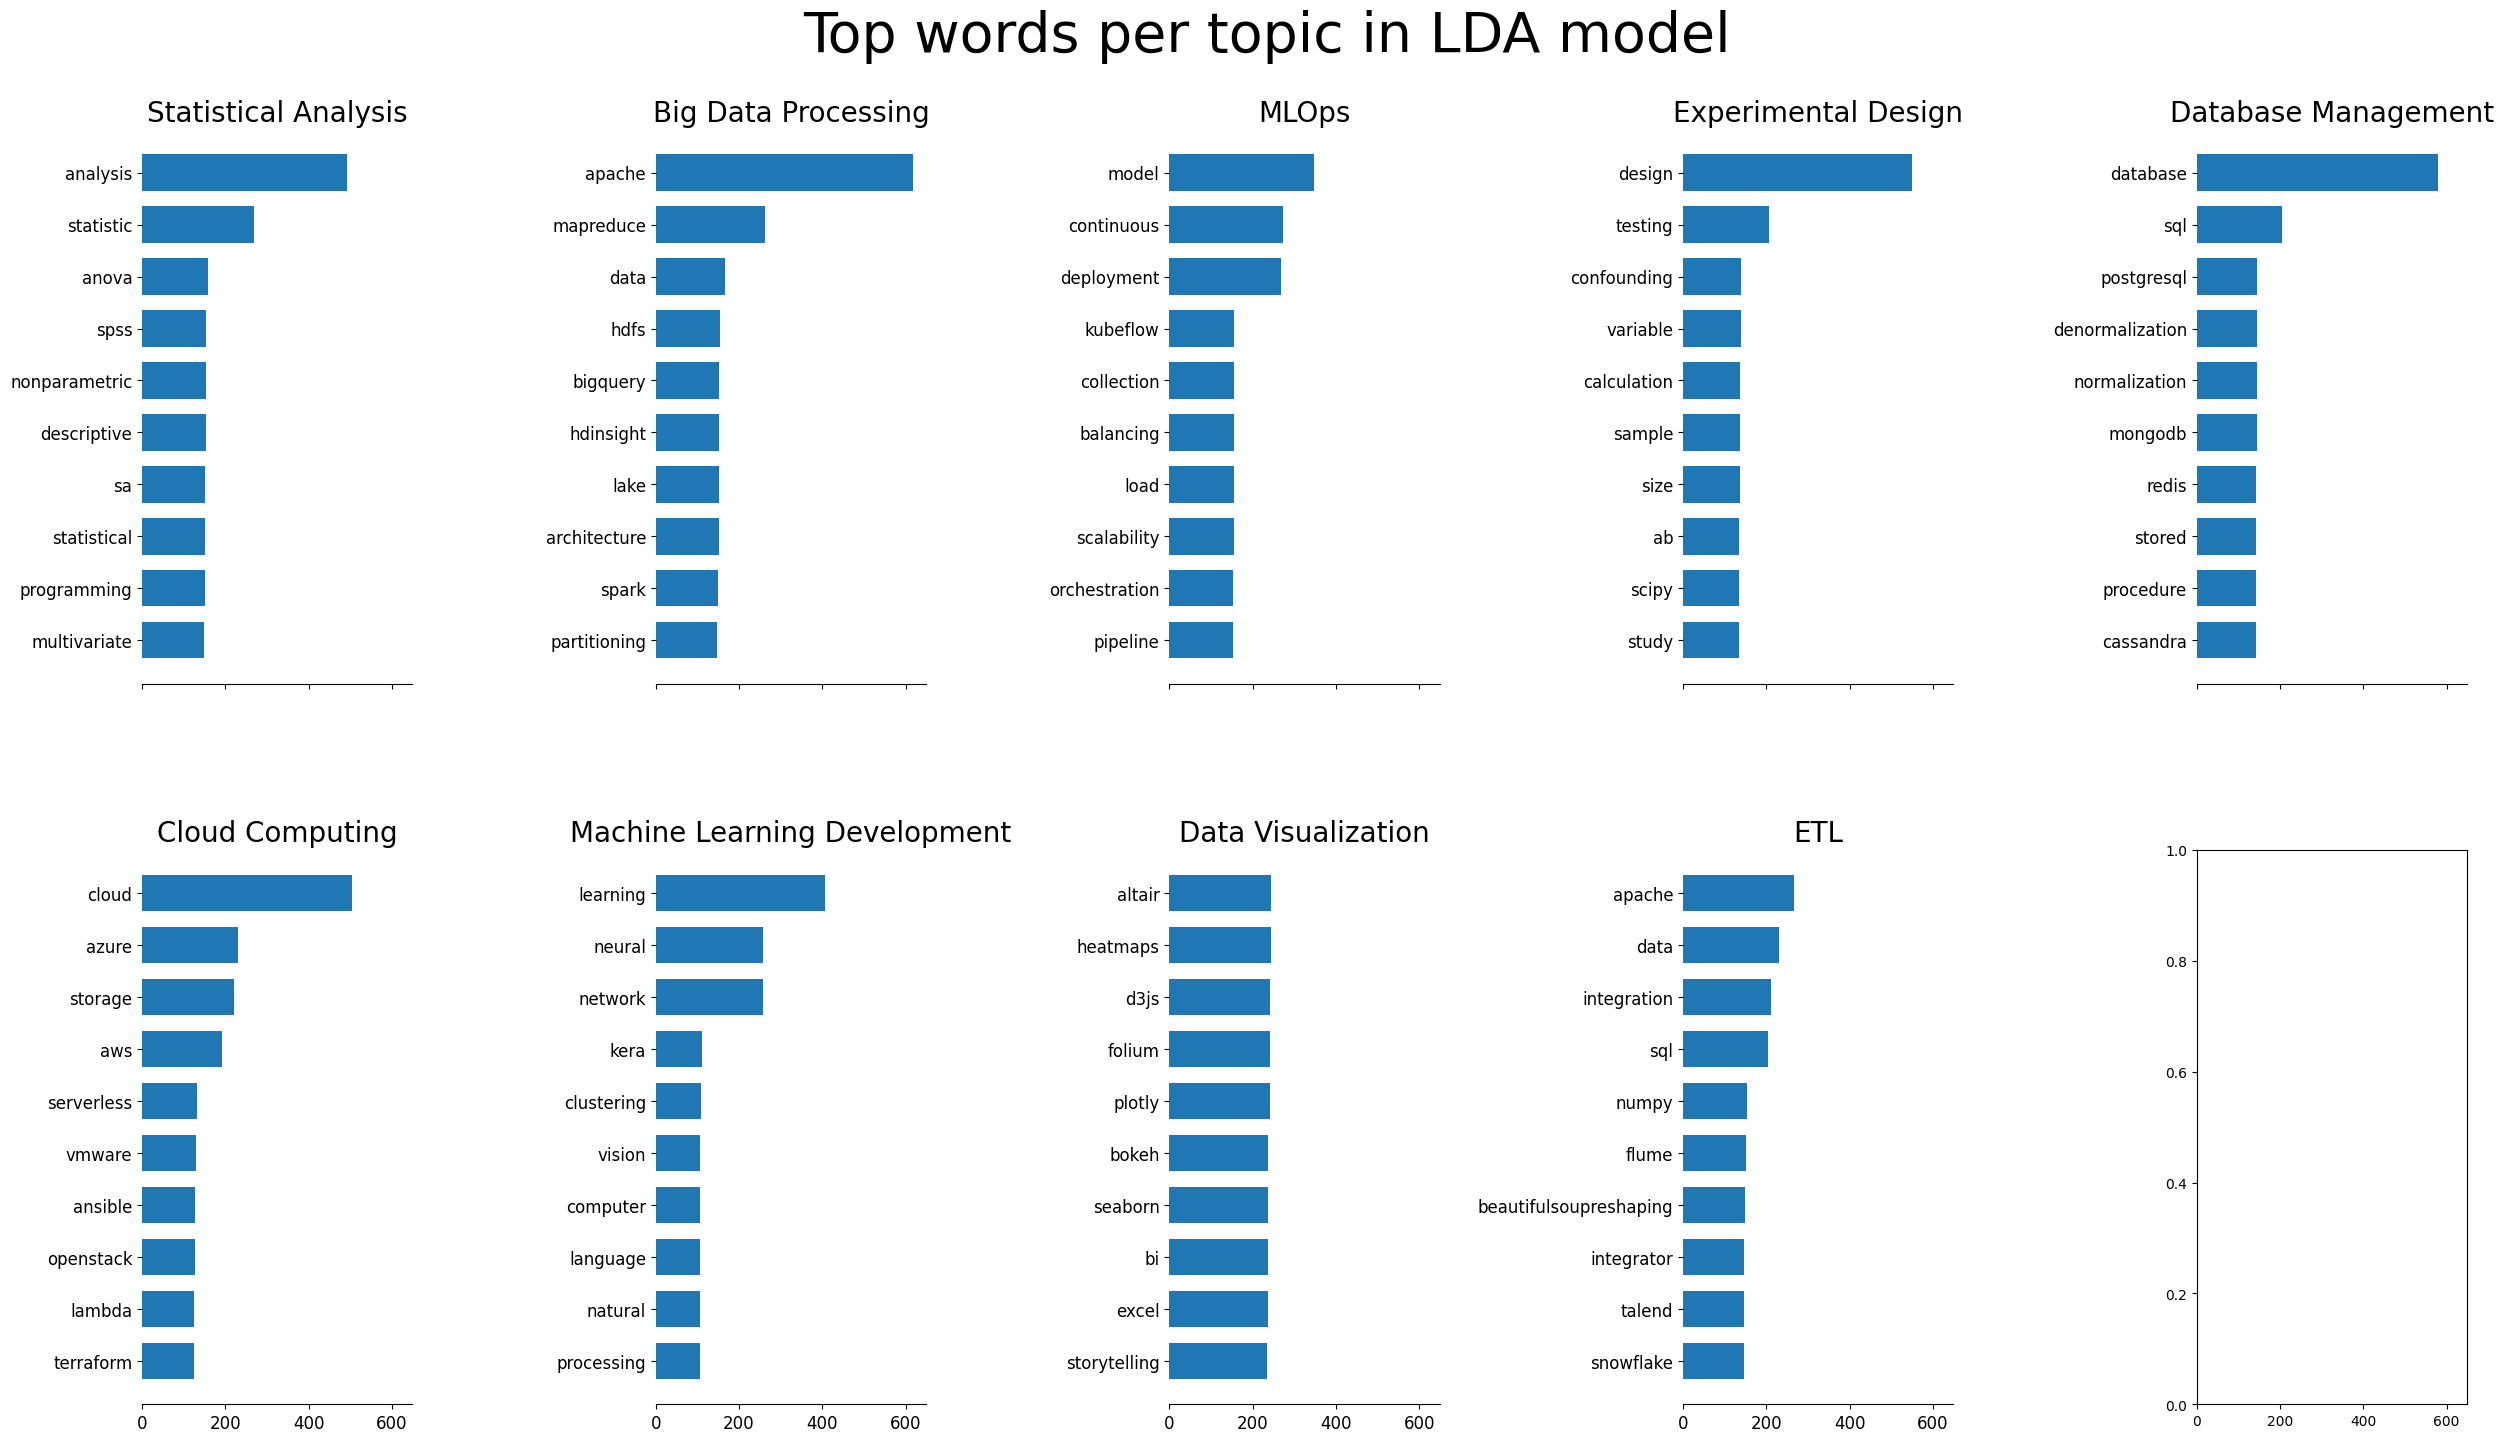

In [147]:
def plot_top_words(model, feature_names, no_top_words, title, topic_names):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'{topic_names[topic_idx]}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, vectorizer.get_feature_names_out(), no_top_words, 'Top words per topic in LDA model', topic_names)

## Assign Tags to Jobs

Assign two tags/topics to each job

In [148]:

job_topic_distribution = lda.transform(tfidf_matrix )
top_2_topics = np.argsort(job_topic_distribution, axis=1)[:, -2:]
df['tag_1'] = top_2_topics[:, 1]
df['tag_2'] = top_2_topics[:, 0]

In [149]:
cluster_to_topic = {i: topic_names[i] for i in range(len(topic_names))}
df['tag_1'] = df['tag_1'].map(cluster_to_topic)
df['tag_2'] = df['tag_2'].map(cluster_to_topic)

In [150]:
df

,main_skill,sub_skill,processed,tag_1,tag_2
0,Big Data Processing,"['Apache Hive', 'Data Partitioning', 'Data Lak...",apache hive data partitioning data lake archit...,Big Data Processing,ETL
1,Big Data Processing,"['Data Partitioning', 'Apache NiFi', 'Data Lak...",data partitioning apache nifi data lake archit...,Big Data Processing,ETL
2,Experimental Design,"['Crossover Design', 'Longitudinal Studies', '...",crossover design longitudinal study design exp...,Experimental Design,Statistical Analysis
3,Big Data Processing,"['Apache Flink', 'Elastic MapReduce', 'Apache ...",apache flink elastic mapreduce apache nifi dat...,Big Data Processing,ETL
4,Database Management,"['NoSQL', 'SQL', 'Indexing', 'MySQL', 'SQLite'...",nosql sql indexing mysql sqlite database secur...,Database Management,Cloud Computing
...,...,...,...,...,...
9995,Cloud Computing,"['AWS', 'Ansible', 'GCP', 'VMware', 'Identity ...",aws ansible gcp vmware identity access managem...,Cloud Computing,MLOps
9996,MLOps,"['Logging and Metrics Collection', 'Jenkins', ...",logging metric collection jenkins model versio...,MLOps,Big Data Processing
9997,Data Visualization,"['Data Storytelling', 'Seaborn', 'Bokeh', 'Plo...",data storytelling seaborn bokeh plotly ggplot2...,Data Visualization,ETL
9998,Experimental Design,"['Power Analysis', 'Confounding Variable Contr...",power analysis confounding variable control de...,Experimental Design,Statistical Analysis


## Inference

The new document can be skills in data science new job posting or candidate resumes

In [160]:
new_doc = """
Tools: Python, R, C#, SAS, MS Excel, Tableau, PowerBI

Skills: Regression Analysis, Hypothesis Testing, Clustering Analysis

"""

new_doc_processed = preprocess(new_doc)
new_doc_vectorized = vectorizer.transform([' '.join(new_doc_processed)])

# Infer the topic distribution for the new document
new_doc_topic_dist = lda.transform(new_doc_vectorized)

In [161]:
print("Topic distribution for the new document:")
print(new_doc_topic_dist)

# Assign the top 2 topics to the new document
top_2_topics = np.argsort(new_doc_topic_dist, axis=1)[:, -2:]
top_2_topics


Topic distribution for the new document:
[[0.48840058 0.0293266  0.0293266  0.0293393  0.0293266  0.0293266
  0.13090545 0.20472164 0.0293266 ]]


array([[7, 0]], dtype=int64)

In [162]:
# Map the cluster indices to tag names
top_topic_1 = topic_names[top_2_topics[0, 1]] #Top1 tag
top_topic_2 = topic_names[top_2_topics[0, 0]] #Top2 tag

print(f"Top 2 tag for the new document: {top_topic_1}, {top_topic_2}")

Top 2 tag for the new document: Statistical Analysis, Data Visualization
